In [1]:
from architectures import *
from training_gan import *

import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.random import PRNGKey as jkey
from flax.core import FrozenDict
from flax.training.train_state import TrainState as RawTrainState
from imax import transforms
from chex import Array, Scalar, PRNGKey
from PIL import Image

# Czy sieci neuronowe śnią o ciastach marchewkowych?
## To chyba nie jest oryginalny Breitling, prawda?
Model dyskriminatora:
```python
def conv_block(x: Array, features: int, training: bool) -> Array:

    x = nn.Conv(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Discriminator(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array, training: bool):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 64, training)
        x = conv_block(x, 128, training)
        x = conv_block(x, 128, training)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        x = nn.Dense(features=1)(x)
        x = nn.sigmoid(x)
        
        return x
```

## Skoro nie widać różnicy..?
Model generatora:
```python
def trans_conv_block(x: Array, features: int) -> Array:

    x = nn.ConvTranspose(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Generator(nn.Module):

    @nn.compact
    def __call__(self, batch: Array):

        batch_size = batch.shape[0]
        x = batch
        x = nn.Dense(features=8192)(x)
        x = jnp.reshape(x, (batch_size, 8, 8, 128))
        x = trans_conv_block(x, 128)
        x = trans_conv_block(x, 256)
        x = trans_conv_block(x, 512)
        x = nn.Conv(features=3, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.sigmoid(x)

        return x
```

In [3]:
# Generuje fotografie z losowego szumu
model = Generator()
dummy_batch_vectors = jax.random.normal(jkey(42), shape=(2, 128)) * jnp.array([[1], [25]])
vars = model.init(jkey(42), dummy_batch_vectors)
pred = model.apply(
    {'params': vars['params']},
    dummy_batch_vectors
)

In [4]:
# Generuje fotografie z losowego szumu
state_gen = create_Generator(42)
dummy_batch_vectors = jax.random.normal(jkey(42), shape=(2, 128)) * jnp.array([[1], [25]])
dummy_pred = generate(state_gen, dummy_batch_vectors)

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 1)$:

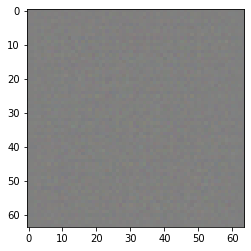

In [5]:
plt.imshow(jnp.squeeze(dummy_pred[0]));

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 25)$:

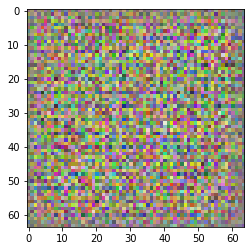

In [7]:
plt.imshow(jnp.squeeze(dummy_pred[1]));

## I zebrano jeszcze dwanaście koszy ułomków

In [8]:
raw_amanita_path = "datasets/amanita_raw"
files = os.listdir(raw_amanita_path)
load_galaxy = lambda file: jnp.array(Image.open(os.path.join(raw_amanita_path, file)).resize((64, 64)))
images = jnp.array(list(map(load_galaxy, files)))

Przykładowe egzemplarze datasetu *galaxies* utworzonego z uyciem biblioteki *jmd_imagescraper*:

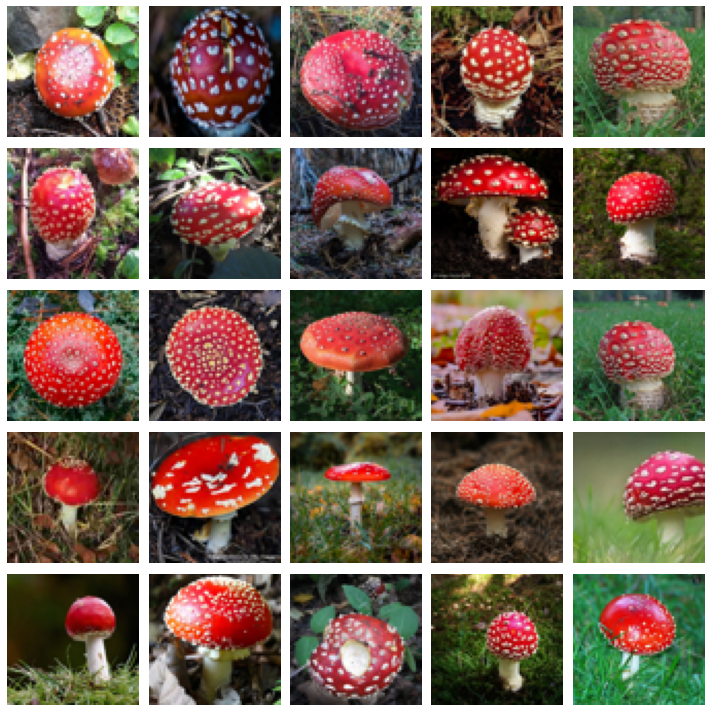

In [9]:
plot_samples(images, subplots_shape=(5, 5))

### Data augmentation
Do operacji "data augmentation" skorzystałem z bibliotki *imax*, która zapewnia mi potrzebne transformacje (odbicia, rotacje, translacje i skalowanie). Ponizszy kod przedsawia stochastyczną modyfikację pojedynczego obrazka, poprzez złozenie operacji obrotu, odbicia w osi pionowej, powiększenia oraz przesunięcia:

In [10]:
def augmentat_img(img, key: PRNGKey):

    key_1, key_2, key_3, key_4, key_5, key_6 = jax.random.split(key, 6)

    rot = transforms.rotate(
        rad=jax.random.uniform(key_1, minval=-jnp.pi / 16, maxval=jnp.pi / 16)
    )
    flip = transforms.flip(
        horizontal=jax.random.uniform(key_2) < 0.5,
        vertical=False
    )
    scale = transforms.scale(
        jax.random.uniform(key_4, minval=1.0, maxval=1.25),
        jax.random.uniform(key_4, minval=1.0, maxval=1.25)
    )
    translate = transforms.translate(
        jax.random.uniform(key_5, minval=-4.0, maxval=4.0),
        jax.random.uniform(key_6, minval=-4.0, maxval=4.0)
    )

    return transforms.apply_transform(img, flip @ rot @ translate @ scale, mask_value=-1)

Data augmentation na małym zbiorze danych (5-elementowym):

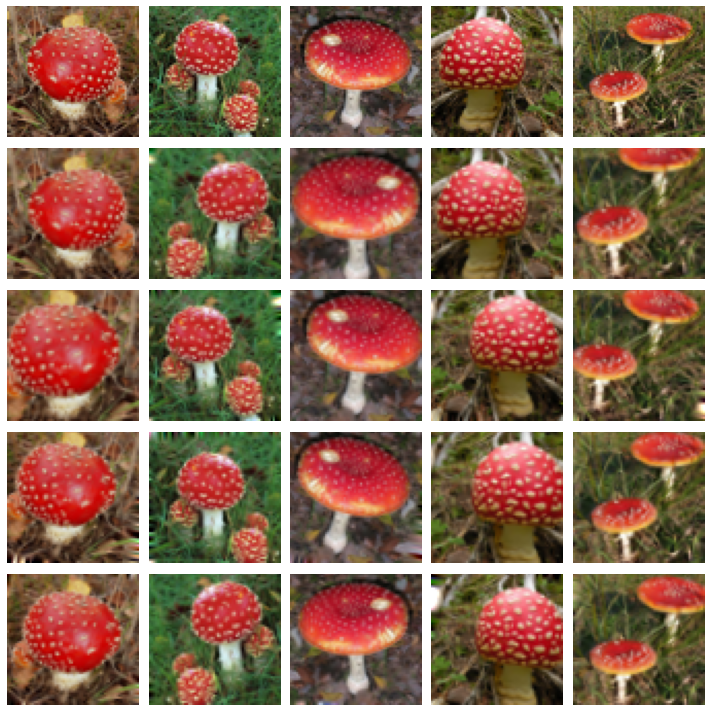

In [15]:
small_ds = images[:5]

key = jkey(44)
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(10, 10)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(small_ds[i])
    ax.axis('off')
for j in range(4):
    for i in range(5):
        key, augment_key = jax.random.split(key)
        ax = axes[1 + j, i]
        ax.imshow(augmentat_img(small_ds[i], augment_key))
        ax.axis('off')
fig.tight_layout()
plt.show()

## Work it harder, make it better
### Prosty rozruch
Przygotowałem model składający się z 2 gęsto połączonych warstw o szerokościach kolejno 8 i 3, aktywowanych funkcją ReLU. W celu wyliczania pochodnych cząstkowych, maskowałem gradient optymalizatora pod odpowiednią warstwą:
```python
opt = optax.multi_transform(
    {"sgd": optax.sgd(learning_rate=lr, momentum=momentum), "zero": zero_grads()},
    {"Dense_0": "sgd", "Dense_1": "zero"}
)
```

Zatem za maskowanie gradientu odpowiada optymalizator, który jest częścią stanu modelu. W moim kodzie, optymalizator jest odpowiednio inicjowany w funkcji `create_SimpleModel`.
Ponizej implementacja treningu z tak maskowanym gradientem oraz wykres krzywej kosztu, obliczanego jako odległośc średniej z wyjścia modelu a liczbą 42:

/Users/wciezobka/ncn/pyncn310/lib/python3.10/site-packages/optax/_src/combine.py:129: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  label_set = set(jax.tree_leaves(labels))


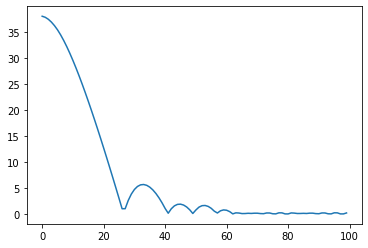

In [12]:
def dummy_loss(params: FrozenDict, batch: Array, state: RawTrainState):

    logits = state.apply_fn(
        {'params': params},
        batch
    )
    
    return jnp.abs(42 - jnp.mean(logits))


@jax.jit
def step_fn(state: RawTrainState, batch: Array):

    # Compute masked gradients
    grad_fn = jax.value_and_grad(dummy_loss)
    loss, grads = grad_fn(state.params, batch, state)

    # Correct weights in the training state
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss


batch = jax.random.uniform(jkey(42), shape=(8, 3)) * 10
state = create_SimpleModel(batch, jkey(42), lr=0.01)

init_params = state.params
loss_acc = []
for i in range(100):

    state, loss = step_fn(state, batch)
    loss_acc.append(loss)
    

final_params = state.params
plt.plot(jnp.arange(len(loss_acc)), jnp.array(loss_acc));

Weryfikacja czy faktycznie wagi w warstwie I pozostały bez zmian:

In [13]:
jax.tree_util.tree_map(lambda x, y: jnp.array_equal(x, y), init_params, final_params)

{'Dense_0': {'bias': DeviceArray(False, dtype=bool),
  'kernel': DeviceArray(False, dtype=bool)},
 'Dense_1': {'bias': DeviceArray(True, dtype=bool),
  'kernel': DeviceArray(True, dtype=bool)}}

PS Co prawda takie maskowanie działa, jednak podczas dalszego przebiegu cwiczenia okazało się zbędne. JAX jest na tyle elastyczą biblioteką, ze pozwala dokładnie wyspecyfikowac po czym rozniczkujemy. Domyślnie funkja `jax.grad(some_fun)` liczy pochodne funkcji `some_fun` po jej pierwszym argumencie, co pozwoliło mi w łatwy sposób określac czy minimalizuje stan dyskryminatora czy stan generatora.

### Uczenie dyskryminatora